# <div align='center'>第2章 参数估计</div>
### 内容<br>
 <div align='left'>                  
     <font color='steelblue' size=4>
       2.1 点估计<br><br>
       2.2 区间估计<br><br>
       </font>
       </div>

-------------------

## 2.1 点估计-极大似然法


### 2.1.1 极大似然法的概念


### 2.1.2 连续函数空间的解析解

In [16]:

import numpy as np
import scipy.stats as st
from  collections import namedtuple 
#均值为2，标准差为10的正态分布随机变量1000个
x = st.norm.rvs(loc=2,scale=10,size=1000)
print('前10个值：',x[0:10])

#通过上述对数似然方程的估计公式，计算均值和标准差
mu = np.sum(x)/len(x)
sigma = np.sqrt(np.sum((x-np.mean(x))**2)/len(x))
print('\n使用极大似然法估计得到的均值mu：%0.2f，标准差sigma为：%0.2f。'%(mu,sigma))

前10个值： [  5.19843205  -1.68282638  12.99181887 -11.92810992 -20.11367779
  17.07255856   0.1609451   -1.39443596  -7.22645477   9.7967091 ]

使用极大似然法估计得到的均值mu：2.45，标准差sigma为：10.14。


### 2.1.3 对数似然方程的数值解
 
以柯西(Couchy)分布为例,该总体分布的概率密度函数的尺度参数为$\gamma$，位置参数$\theta$。当尺度参数为1，位置参数为0时，称之为柯西分布的标准化形式或标准柯西分布。



In [17]:

from scipy.optimize import fsolve,root
#生成模拟数据
data = st.cauchy.rvs(loc=15,scale=1,size = 100)
#对数似然方程
def func(theta,x):
    return np.sum((x-theta)/(1+(x-theta)**2))
result = fsolve(func,np.median(data),args=data)
print('fsolve函数求解：',result)
result1 = root(func,np.median(data),args=data)
print('root函数求解',result1.x)
print('模拟数据的中位数：',np.median(data))

fsolve函数求解： [14.77620176]
root函数求解 [14.77620176]
模拟数据的中位数： 14.700203658768027


- #### 牛顿法



In [18]:

def cauchy_mle(x,theta):
    sum = 0
    for i in range(0,len(x)):
        sum = sum+(x[i]-theta)/(1+(x[i]-theta)**2)
    return sum

#对数似然函数的一阶导数
def cauchy_mle_der(x,theta):
    sum = 0  
    for i in range(0,len(x)):
        tmp = (x[i]-theta)**2
        sum = sum+(tmp-1)/(1+tmp)**2
    return sum

#用样本中位数作为初始估计值
theta=np.median(data)

#迭代次数控制，当前一次迭代值与当前迭代值小于0.001时停止迭代。
#说明已经收敛。
std_diff=1e-18

while True:##无限循环
    ###牛顿法的迭代公式
    theta1 = theta - cauchy_mle(data,theta)/cauchy_mle_der(data,theta)
    ###当本次迭代的数值解和上次迭代数值解之差的绝对值小于阈值时，停止迭代，
    if np.abs(theta1-theta)<=std_diff:
        break
    else:
        theta=theta1
    print(theta)


14.776896057177604
14.776201803565757
14.776201763287403


-------------------

## 2.2 区间估计


### 2.2.1 单个正态总体的均值$\mu$的区间估计


In [19]:
#命名元组，用来保存函数返回结果
MuResultSet = namedtuple('MuResultSet',['Mean','DF','Lower','Upper'])
def interval_mu(x, sigma=-1,alpha=0.05):
    n = len(x)#样本量
    m = np.mean(x)#样本均值
    
    #根据方差已知与否计算上下限的加减量
    if sigma >= 0:#总体方差已知
        tmp = (sigma/np.sqrt(n))*st.norm.ppf(1-alpha/2)
        df = n
    else:#总体方差未知
        tmp = (st.tstd(x)/np.sqrt(n))*st.t.ppf(1-alpha/2,n-1)
        df = n-1
    lower = m - tmp#置信下限
    upper = m + tmp#置信上限
    
    result = MuResultSet(Mean=np.round(m,2),DF=df,
                         Lower=np.round(lower,6),
                         Upper=np.round(upper,6))
    return result

In [20]:
'''
示例：某机器零件的长度服从N(mu,0.04)分布，随机抽取样本长度如下(单位：mm)：
    14.6,15.1,14.9,14.8,15.2,15.1
    求零件长度的置信区间0.95的区间估计。
'''
lengths = np.array([14.6,15.1,14.9,14.8,15.2,15.1])
interval_mu(lengths,0.2)

MuResultSet(Mean=14.95, DF=6, Lower=14.78997, Upper=15.11003)

In [21]:
'''
示例：抽样某零件样品的重量共10次，(单位：kg)，分别为：
    10.1,10,9.8,10.5,9.7,10.1,9.9,10.2,10.3,9.9
    求零件长度的置信区间0.95的区间估计。
'''
weights = np.array([10.1,10,9.8,10.5,9.7,10.1,9.9,10.2,10.3,9.9])
interval_mu(weights)

MuResultSet(Mean=10.05, DF=9, Lower=9.877225, Upper=10.222775)

In [22]:
#零件长度的置信区间，方差已知，使用正态分布的interval函数
#此处方差已知，所以直接使用0.2,即方差0.04的平方根
interv1 = st.norm.interval(0.95,loc = np.mean(lengths),scale = 0.2/np.sqrt(6))
print('通过Scipy的interval函数计算置信区间（方差已知）：',np.round(interv1,6))

#零件重量的置信区间，方差未知，使用t分布的interval函数
#此处第4个参数同样使用标准误，可以调用scipy的tsem函数计算样本数据的标准误
interv2 = st.t.interval(0.95,df = len(weights)-1,loc=np.mean(weights),
                        scale=st.tsem(weights))
print('通过Scipy的interval函数计算置信区间（方差未知）：',np.round(interv2,6))

通过Scipy的interval函数计算置信区间（方差已知）： [14.78997 15.11003]
通过Scipy的interval函数计算置信区间（方差未知）： [ 9.877225 10.222775]


### 2.2.2 单个正态总体的方差$\sigma^2$的区间估计


In [23]:
'''
单个正态总体的方差区间估计，分两种情况：均值已知和均值未知
可以用来测量数据的误差大小。
'''
from  collections import namedtuple 
#命名元组，用来保存函数返回结果
VarResultSet = namedtuple('VarResultSet',['Var','DF','Lower','Upper'])
def interval_var(x, mu=float('Inf'),alpha=0.05):
    n = len(x)#样本量
    
    if mu < float('Inf'):#均值已知
        S2 = np.sum((x-mu)**2)/n
        df = n
    else:#均值未知
        S2 = st.tvar(x)#使用方差的无偏估计，与np.var区分开。
        df = n-1
    
    lower = df*S2/st.chi2.ppf(1-alpha/2,df)
    upper = df*S2/st.chi2.ppf(alpha/2,df)
    
    result = VarResultSet(Var=S2,DF=df,Lower=np.round(lower,6),Upper=np.round(upper,6))
    return result

In [24]:
'''
示例：抽样某零件样品的重量共10次，(单位：kg)，分别为：
    10.1,10,9.8,10.5,9.7,10.1,9.9,10.2,10.3,9.9
    求零件长度的测量误差，分为已知均值为10和未知均值两种情况。
    结果显示，在均值已知的情况下，计算结果更好，即置信区间更窄。
'''
weights = np.array([10.1,10,9.8,10.5,9.7,10.1,9.9,10.2,10.3,9.9])
#已知均值为10
print('已知均值为10的方差置信区间:',interval_var(weights,10))
#均值未知
print('未知均值的方差置信区间:',interval_var(weights))

已知均值为10的方差置信区间: VarResultSet(Var=0.05499999999999999, DF=10, Lower=0.026851, Upper=0.169389)
未知均值的方差置信区间: VarResultSet(Var=0.05833333333333332, DF=9, Lower=0.027599, Upper=0.194416)


### 2.2.3 两个正态总体均值 $\mu_1$-$\mu_2$ 的区间估计

In [25]:
'''
在实际工作中，经常需要比较两个数据之间的平均值是否存在差异，
比如在教学科研中，需比较新老两种教学方法的效果是否存在差异，
那么就可以对两种方法的学生成绩的均值进行比较，如果存在显著差异即是效果，
反之则无差别。
'''
def interval_mu2(x,y,sigma=np.array([-1,-1]),vareq=False,alpha=0.05):
    n1 = len(x)
    n2 = len(y)
    mx = np.mean(x)
    my = np.mean(y)
    
    if np.all(sigma>0):#两个独立样本的方差已知
        #根据上述公式计算置信区间上、下限的加、减量
        tmp = st.norm.ppf(1-alpha/2)*np.sqrt(sigma[0]**2/n1+sigma[1]**2/n2)
        df = n1+n2
    else:
        if vareq:#两个独立样本的方差相等且未知
            sw = ((n1-1)*st.tvar(x)+(n2-1)*st.tvar(y))/(n1+n2-2)
            tmp = np.sqrt(sw*(1/n1+1/n2))*st.t.ppf(1-alpha/2,n1+n2-2)
            df = n1+n2-2
        else:#两个独立样本的方差不相等且未知
            s1 = st.tvar(x)
            s2 = st.tvar(y)
            nu = ((s1/n1+s2/n2)**2)/(s1**2/(n1**2*(n1-1))+s2**2/(n2**2*(n2-1)))
            tmp = st.t.ppf(1-alpha/2,nu)*np.sqrt(s1/n1+s2/n2)
            df = nu
    result = MuResultSet(Mean=mx-my,DF=df,
                         Lower=np.round(mx-my-tmp,6),
                         Upper=np.round(mx-my+tmp,6))
    return result

- #### 示例：
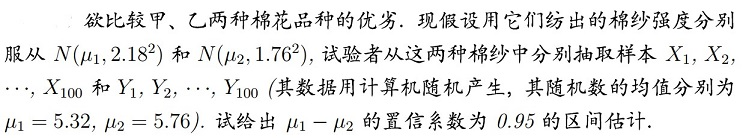

In [26]:
'''
示例：比较棉花品种优劣，方差已知。
'''
#根据均值和标准差生成两个独立样本数据
x = st.norm.rvs(loc=5.32,scale=2.18,size=100)
y = st.norm.rvs(loc=5.76,scale=1.76,size=100)

#调用区间估计函数，方差已知
result = interval_mu2(x,y,np.array([2.18,3.76])) 
print('mu1-mu2置信水平0.95的区间估计为：',result)

#调用t检验函数，原假设是两个独立样本具有相同均值
result1 = st.ttest_ind(x,y,equal_var=False)
print('调用Scipy的t检验函数：',result1)

mu1-mu2置信水平0.95的区间估计为： MuResultSet(Mean=-0.7545086097395775, DF=200, Lower=-1.60636, Upper=0.097343)
调用Scipy的t检验函数： Ttest_indResult(statistic=-2.6567913400896224, pvalue=0.008604393572159667)


- #### 示例：
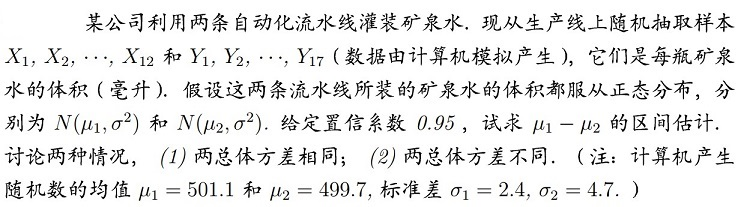

In [27]:
'''
示例：比较矿泉水体积，方差未知，相同和不相同两种情况。
下述程序运行结果表明，无论何种检验方式，都不能拒绝两条流水线上生辰的矿泉水体积相等。
区间估计表明上限大于零，下限小于零，即区间包含了零。
t检验的p值大于0.05，不能拒绝两个独立样本的均值相等的原假设。
在假设方差不同的情况下，计算结果更加精确，即置信区间更窄。
'''
x = st.norm.rvs(501.1,2.4,12)
y = st.norm.rvs(499.7,4.7,17)
#方差未知，且相同
result1 = interval_mu2(x,y,vareq=True)
print('方差未知且相同：',result1)
#方差未知，且不同
result2 = interval_mu2(x,y)
print('方差未知且不同:',result2)

#下面调用Scipy的t检验函数，分为方差相同和不同
result3 = st.ttest_ind(x,y,equal_var=True)
print('t检验，方差相同：',result3)
result4 = st.ttest_ind(x,y,equal_var=False)
print('t检验，方差不同：',result4)

方差未知且相同： MuResultSet(Mean=1.0349320762243224, DF=27, Lower=-2.335798, Upper=4.405662)
方差未知且不同: MuResultSet(Mean=1.0349320762243224, DF=22.64783987599828, Lower=-1.959092, Upper=4.028956)
t检验，方差相同： Ttest_indResult(statistic=0.6299838265950031, pvalue=0.534000814127331)
t检验，方差不同： Ttest_indResult(statistic=0.7156802323794383, pvalue=0.4815030308455729)


### 2.2.4 两个正态总体的方差比$\sigma^2_1$/$\sigma^2_2$的区间估计


In [28]:
'''
方差用来描述数据的分散程度
'''
VRateResultSet = namedtuple('VRateResultSet',['Rate','DF1','DF2','Lower','Upper'])
def interval_var2(x,y,mu=np.array([float('Inf'),float('Inf')]),alpha=0.05):
    n1 = len(x)#样本量
    n2 = len(y)
    
    if np.all(mu < float('Inf')):#均值已知
        #根据已知均值计算方差
        Sx2 = 1/n1*np.sum((x-mu[0])**2)
        Sy2 = 1/n2*np.sum((y-mu[1])**2)
        df1 = n1
        df2 = n2        
    else:#均值未知
        #直接计算样本方差作为总体方差的无偏估计，此时自由度等于：样本量-1
        Sx2 = st.tvar(x)
        Sy2 = st.tvar(y)
        df1 = n1-1
        df2 = n2-1
    rate = Sx2/Sy2
    lower = rate/st.f.ppf(1-alpha/2,df1,df2)
    upper = rate/st.f.ppf(alpha/2,df1,df2)
    result = VRateResultSet(Rate=rate,DF1=df1,DF2=df2,
                            Lower=np.round(lower,6),
                            Upper=np.round(upper,6))
    return result

#### 示例：
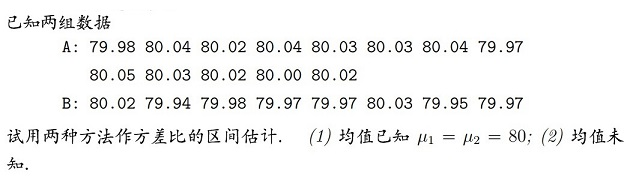

In [29]:
'''
示例：比较两组数据的方差，也就数据的波动情况
'''
x = np.array([79.98,80.04, 80.02, 80.04, 80.03, 80.03, 80.04, 79.97,
              80.05, 80.03, 80.02, 80.00, 80.02])
y = np.array([80.02, 79.94, 79.98, 79.97, 79.97, 80.03, 79.95, 79.97])
#均值已知
result1 = interval_var2(x,y,np.array([80,80]))
print('均值已知的方差比：',result1)
#均值未知
result2 = interval_var2(x,y)
print('均值未知的方差比：',result2)

均值已知的方差比： VRateResultSet(Rate=0.7326007326007866, DF1=13, DF2=8, Lower=0.176014, Upper=2.482042)
均值未知的方差比： VRateResultSet(Rate=0.5837405184048123, DF1=12, DF2=7, Lower=0.12511, Upper=2.105269)


In [30]:
'''
使用f分布的interval函数计算方差比的置信区间，分为已知均值和未知均值两种
'''
#注意：自由度设置顺序，第一个自由度为分母的自由度，第二个为分子的自由度。scale为x和y的方差之比
result1 = st.f.interval(0.95,len(y),len(x),
                        scale=(np.sum((x-80)**2)/len(x))/(np.sum((y-80)**2)/len(y)))
print('使用Scipy计算方差比置信区间(均值已知)：',np.round(result1,6))

#使用样本方差作为总体方差的无偏估计，则自由度分别减1。
result2 = st.f.interval(0.95,len(y)-1,len(x)-1,scale=st.tvar(x)/st.tvar(y))
print('使用Scipy计算方差比置信区间(均值未知)：',np.round(result2,6))

使用Scipy计算方差比置信区间(均值已知)： [0.176014 2.482042]
使用Scipy计算方差比置信区间(均值未知)： [0.12511  2.105269]


### 2.2.5 非正态分布总体均值的区间估计


In [31]:
'''
利用中心极限定理，将无法肯定符合正态分布的数据转换成正态分布的区间估计问题。
'''
NNResultSet = namedtuple('NNResultSet',['Mean','Lower','Upper'])
def interval_mu3(x,sigma=-1,alpha=0.05):
    n = len(x)
    mx = np.mean(x)
    if sigma>0:
        tmp = sigma/np.sqrt(n)*st.norm.ppf(1-alpha/2)
    else:
        tmp = st.tstd(x)/np.sqrt(n)*st.norm.ppf(1-alpha/2)
    return NNResultSet(Mean = mx,Lower=np.round(mx-tmp,6),Upper=np.round(mx+tmp,6))

- #### 示例：
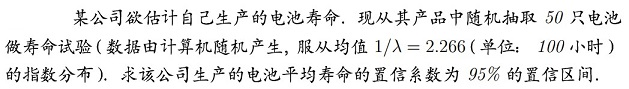

In [32]:
'''
示例：将符合指数分布的电池寿命数据转换成正态分布的均值区间估计
'''
#生成样本数据。样本量越大，区间估计越精确
x = st.expon.rvs(scale=2.266,size=1000)
#方差未知
result1 = interval_mu3(x)
print('方差未知的非正态总体均值区间估计：',result1)
#调用Scipy的interval函数估计区间，方差未知。
result2 = st.norm.interval(0.95,loc = np.mean(x),scale=st.tstd(x)/(len(x)**0.5))
print('调用interval函数估计非正态总体均值置信区间：',np.round(result2,6))

方差未知的非正态总体均值区间估计： NNResultSet(Mean=2.243309669076189, Lower=2.105121, Upper=2.381498)
调用interval函数估计非正态总体均值置信区间： [2.105121 2.381498]


### 2.2.6 单侧置信区间估计


In [33]:
'''
一个总体的均值单侧置信区间估计的用途也比较广泛，比如设备、元件等只关心最低寿命，即平均寿命的下限
对产品的生产一般只关心最大废品率，也就是废品率的上限。
'''
UniMuResultSet = namedtuple('UniMuResultSet',['Mean','DF','Lower','Upper'])
def interval_mu4(x, sigma=-1,side='two-sided',alpha=0.05):
    n=len(x)
    mx=np.mean(x)
    if sigma>0:#已知总体方差
        if side=='upper':#单侧置信上限
            tmp=sigma/np.sqrt(n)*st.norm.ppf(1-alpha)
            lower=float('-Inf')
            upper=mx+tmp
        elif side=='lower':#单侧置信下限
            tmp=sigma/np.sqrt(n)*st.norm.ppf(1-alpha)
            lower=mx-tmp
            upper=float('Inf')
        elif side=='two-sided':#双侧置信区间
            #当进行双侧置信区间估计时，分位数的概率为1-alpha/2或alpha/2
            tmp=sigma/np.sqrt(n)*st.norm.ppf(1-alpha/2)
            lower=mx-tmp
            upper=mx+tmp
        df=n
    else:#总体方差未知
        if side=='upper':#置信上限
            tmp=st.tstd(x)/np.sqrt(n)*st.t.ppf(1-alpha,n-1)
            lower=float('-Inf')
            upper=mx+tmp
        elif side=='lower':#单侧置信下限
            tmp=st.tstd(x)/np.sqrt(n)*st.t.ppf(1-alpha,n-1)
            lower=mx-tmp
            upper=float('Inf')
        elif side=='two-sided':#双侧置信区间
            #当进行双侧置信区间估计时，分位数的概率为1-alpha/2或alpha/2
            tmp=st.tstd(x)/np.sqrt(n)*st.t.ppf(1-alpha/2,n-1)
            lower=mx-tmp
            upper=mx+tmp
        df=n-1
    return UniMuResultSet(Mean=mx,DF=df,Lower=np.round(lower,6),Upper=np.round(upper,6))

In [34]:
'''
示例：从一批零件中随机抽取10只做寿命测试，测得寿命（单位：小时）如下：
    1067,919,1196,785,1126,936,918,1156,920,948
零件寿命服从正态分布，求寿命平均值的置信度为0.95的单侧置信下限。
'''
#未知总体方差的情况下的单侧置信下限。
x = np.array([1067,919,1196,785,1126,936,918,1156,920,948])
#计算零件寿命的单侧置信下限，即95%的零件寿命大于多少
result1 = interval_mu4(x,side='lower')
print('单侧置信下限：',result1)

#Scipy在求单侧置信区间的上限或下限时，其实就是求标准误在概率分布为5%时的百分位数
result2 = st.t.ppf(0.05,df = len(x)-1,loc=np.mean(x),scale=st.tstd(x)/len(x)**0.5)
print('Scipy求单侧置信下限：',np.round(result2,6))

单侧置信下限： UniMuResultSet(Mean=997.1, DF=9, Lower=920.844338, Upper=inf)
Scipy求单侧置信下限： 920.844338


In [35]:
#计算零件寿命的单侧置信上限，即95%的零件寿命小于多少
result3 = interval_mu4(x,side='upper')
print('单侧置信下限：',result3)

#Scipy在求单侧置信区间的上限或下限时，就是求标准误在概率分布为95%时的百分位数
result4 = st.t.ppf(0.95,df = len(x)-1,loc=np.mean(x),scale=st.tstd(x)/len(x)**0.5)
print('Scipy求单侧置信上限：',np.round(result4,6))

单侧置信下限： UniMuResultSet(Mean=997.1, DF=9, Lower=-inf, Upper=1073.355662)
Scipy求单侧置信上限： 1073.355662


In [36]:

#上文中result4的计算公式可以分解如下：t分布百分数*标准误+均值，
#其实就是前述公式图片和自定义函数中的计算公式
result4_1 = st.t.ppf(0.95,df=len(x)-1)*st.tstd(x)/len(x)**0.5+np.mean(x)
print('ppf计算单侧置信区间的分解(单侧置信上限)：',np.round(result4_1,6))

ppf计算单侧置信区间的分解(单侧置信上限)： 1073.355662


In [37]:
'''
双侧置信区间的计算以及分解
'''
#利用interval函数计算双侧置信区间，结果与interval_mu4一致（设side='two-sided'）
result5_1 = st.t.interval(0.95,df=len(x)-1,loc=np.mean(x),scale=st.tstd(x)/len(x)**0.5)
print('interval函数计算双侧置信区间：',np.round(result5_1,6))
#ppf函数分别计算双侧置信区间的上限和下限。注意：和计算单侧置信区间的上下限是有区别的。
result5_2 = st.t.ppf(0.975,df=len(x)-1,loc=np.mean(x),scale=st.tstd(x)/len(x)**0.5)
print('ppf函数计算双侧置信区间的上限：',np.round(result5_2,6))
result5_3 = st.t.ppf(0.025,df=len(x)-1,loc=np.mean(x),scale=st.tstd(x)/len(x)**0.5)
print('ppf函数计算双侧置信区间的下限：',np.round(result5_3,6))
result5_4 = interval_mu4(x,side='two-sided')
print('interval_mu4函数计算双侧置信区间：',result5_4)

interval函数计算双侧置信区间： [ 902.996528 1091.203472]
ppf函数计算双侧置信区间的上限： 1091.203472
ppf函数计算双侧置信区间的下限： 902.996528
interval_mu4函数计算双侧置信区间： UniMuResultSet(Mean=997.1, DF=9, Lower=902.996528, Upper=1091.203472)


#### (2)单总体方差$\sigma^2$的单侧置信区间


In [38]:
'''
单个总体的方差单侧置信区间用途也很广泛
'''
UniVarResultSet = namedtuple('UniVarResultSet',['Var','DF','Lower','Upper'])
def interval_var3(x,mu=float('Inf'),side='two-sided',alpha=0.05):
    n=len(x)
    if mu<float('Inf'):
        S2=np.sum((x-mu)**2)/n
        df=n
    else:
        S2=st.tvar(x)
        df=n-1
    if side=='upper':#置信上限
        lower=0
        upper=df*S2/st.chi2.ppf(alpha,df)
    elif side=='lower':#置信下限
        lower=df*S2/st.chi2.ppf(1-alpha,df)
        upper=float('Inf')
    elif side=='two-sided':#双侧置信区间
        lower=df*S2/st.chi2.ppf(1-alpha/2,df)
        upper=df*S2/st.chi2.ppf(alpha/2,df)
    
    return UniVarResultSet(Var=np.round(S2,7),DF=df,
                           Lower=np.round(lower,7),
                           Upper=np.round(upper,7))

In [39]:
'''
计算前述零件重量的例子，比较关心重量的最大误差是多少

示例：抽样某零件样品的重量共10次，(单位：kg)，分别为：
    10.1,10,9.8,10.5,9.7,10.1,9.9,10.2,10.3,9.9
    求零件重量方差的单侧置信区间上限，即其最大误差是多少。
'''
x=np.array([10.1,10,9.8,10.5,9.7,10.1,9.9,10.2,10.3,9.9])
print('自定义函数interval_var3求解置信上限：',interval_var3(x,side='upper'))
print('自定义函数interval_var3求解置信下限：',interval_var3(x,side='lower'))

自定义函数interval_var3求解置信上限： UniVarResultSet(Var=0.0583333, DF=9, Lower=0, Upper=0.1578894)
自定义函数interval_var3求解置信下限： UniVarResultSet(Var=0.0583333, DF=9, Lower=0.0310302, Upper=inf)


- #### 通过ppf函数求解单侧置信区间


In [40]:
###ppf函数的loc和scale两个参数的涵义和用法
st.chi2.ppf(0.05,9),st.chi2.ppf(0.05,9,scale=10),\
st.chi2.ppf(0.05,9,loc=3),st.chi2.ppf(0.05,9,loc=3,scale=10)

(3.325112843066815, 33.251128430668146, 6.325112843066815, 36.251128430668146)

In [41]:
###ppf(p, ..., loc, scale)=ppf(p, ...)*scale+loc
st.chi2.ppf(0.05,9)*10+3

36.251128430668146

- #### $\mu$未知的总体方差单侧置信下限、上限



In [42]:
#ppf函数求置信上限
result1 = 1/st.chi2.ppf(0.05,df=len(x)-1,scale=1/((len(x)-1)*st.tvar(x)))
print('ppf函数求置信上限：',np.round(result1,6))
#ppf函数计算置信下限
result2 = 1/st.chi2.ppf(0.95,df=len(x)-1,scale=1/((len(x)-1)*st.tvar(x)))
print('ppf函数求置信下限：',np.round(result2,6))

ppf函数求置信上限： 0.157889
ppf函数求置信下限： 0.03103


#### (3) 两个总体求均值之差$\mu_1$-$\mu_2$单侧置信区间上、下限



In [43]:
'''
两个总体求均值之差的单侧置信区间，如果已知总体的方差，则是使用总体方差。
如果未知，则使用样本方差的无偏估计代替。
'''
DsMuResultSet = namedtuple('DsMuResultSet',['Mean','DF','Lower','Upper'])
def interval_mu5(x,y, sigma=np.array([-1,-1]),vareq=False,side='two-sided',alpha=0.05):
    n1=len(x)
    n2=len(y)
    mx=np.mean(x)
    my=np.mean(y)
    diff=mx-my
    if np.all(sigma>=0):
        if side=='upper':#置信上限
            tmp=st.norm.ppf(1-alpha)*np.sqrt(sigma[0]**2/n1+sigma[1]**2/n2)
            lower=float('-Inf')
            upper=diff+tmp
        elif side=='lower':#置信下限
            tmp=st.norm.ppf(1-alpha)*np.sqrt(sigma[0]**2/n1+simga[1]**2/n2)
            lower=diff-tmp
            upper=float('Inf')
        elif side=='two-sided':#双侧置信区间
            tmp=st.norm.ppf(1-alpha/2)*np.sqrt(sigma[0]**2/n1+sigma[1]**2/n2)
            lower=diff-tmp
            upper=diff+tmp
        df=n1+n2
    else:
        if vareq:
            sw=((n1-1)*st.tvar(x)+(n2-1)*st.tvar(y))/(n1+n2-2)
            if side=='upper':
                tmp=np.sqrt(sw*(1/n1+1/n2))*st.t.ppf(1-alpha,n1+n2-2)
                lower=float('-Inf')
                upper=diff+tmp
            elif side=='lower':
                tmp=np.sqrt(sw*(1/n1+1/n2))*st.t.ppf(1-alpha,n1+n2-2)
                lower=diff-tmp
                upper=float('Inf')
            elif side=='two-sided':
                tmp=np.sqrt(sw*(1/n1+1/n2))*st.t.ppf(1-alpha/2,n1+n2-2)
                lower=diff-tmp
                upper=diff+tmp
            df=n1+n2-2
        else:
            s1=st.tvar(x)
            s2=st.tvar(y)
            nu=(s1/n1+s2/n2)**2/(s1**2/n1**2/(n1-1)+s2**2/n2**2/(n2-1))
            if side=='upper':
                tmp=st.t.ppf(1-alpha,nu)*np.sqrt(s1/n1+s2/n2)
                lower=float('-Inf')
                upper=diff+tmp
            elif side=='lower':
                tmp=st.t.ppf(1-alpha,nu)*np.sqrt(s1/n1+s2/n2)
                lower=diff-tmp
                upper=float('Inf')
            elif side=='two-sided':
                tmp=st.t.ppf(1-alpha/2,nu)*np.sqrt(s1/n1+s2/n2)
                lower=diff-tmp
                upper=diff+tmp
            df=nu
    return DsMuResultSet(Mean=np.round(diff,6),
                         DF=np.round(df,6),
                         Lower=np.round(lower,6),
                         Upper=np.round(upper,6))

In [44]:
'''
应用前述灌装水例子
'''
x = st.norm.rvs(501.1,2.4,12)
y = st.norm.rvs(499.7,4.7,17)
#单侧置信区间上限、下限以及双侧置信区间的计算结果
interval_mu5(x,y,side='upper'),interval_mu5(x,y,side='lower'),\
interval_mu5(x,y,side='two-sided')

(DsMuResultSet(Mean=1.100398, DF=26.537474, Lower=-inf, Upper=3.249745),
 DsMuResultSet(Mean=1.100398, DF=26.537474, Lower=-1.048948, Upper=inf),
 DsMuResultSet(Mean=1.100398, DF=26.537474, Lower=-1.489276, Upper=3.690073))

#### (4)两个总体方差比$\sigma^2_1$ /$\sigma^2_2$ 的单侧置信区间估计


In [45]:
'''
比较两个样本数据测量的误差大小，特别是方差比的单侧置信下限、上限
'''
DsVRateResultSet = namedtuple('DsVRateResultSet',['Rate','DF1','DF2','Lower','Upper'])
def interval_var4(x,y,mu=np.array([float('Inf'),float('Inf')]),side='two-sided',alpha=0.05):
    n1=len(x)
    n2=len(y)
    if np.all(mu<float('Inf')):
        sx2=1/n1*np.sum((x-mu[0])**2)
        df1=n1
        sy2=1/n2*np.sum((y-mu[1])**2)
        df2=n2
    else:
        sx2=st.tvar(x)
        sy2=st.tvar(y)
        df1=n1-1
        df2=n2-1
    rate=sx2/sy2
    if side=='upper':
        lower=0
        upper=rate/st.f.ppf(alpha,df1,df2)
    elif side=='lower':
        lower=rate/st.f.ppf(1-alpha,df1,df2)
        upper=float('Inf')
    elif side=='two-sided':
        lower=rate/st.f.ppf(1-alpha/2,df1,df2)
        upper=rate/st.f.ppf(alpha/2,df1,df2)
    
    return DsVRateResultSet(Rate=np.round(rate,6),
                            DF1=df1,DF2=df2,
                            Lower=np.round(lower,6),
                            Upper=np.round(upper,6))    

In [46]:
'''
仍用上文中方差比双侧置信区间的例子。
'''
x = np.array([79.98,80.04, 80.02, 80.04, 80.03, 80.03, 80.04, 79.97,
              80.05, 80.03, 80.02, 80.00, 80.02])
y = np.array([80.02, 79.94, 79.98, 79.97, 79.97, 80.03, 79.95, 79.97])
#单侧置信区间的上限、下限，双侧置信区间
interval_var4(x,y,side='upper'),interval_var4(x,y,side='lower'), \
interval_var4(x,y,side='two-sided')

(DsVRateResultSet(Rate=0.583741, DF1=12, DF2=7, Lower=0, Upper=1.700645),
 DsVRateResultSet(Rate=0.583741, DF1=12, DF2=7, Lower=0.163299, Upper=inf),
 DsVRateResultSet(Rate=0.583741, DF1=12, DF2=7, Lower=0.12511, Upper=2.105269))

In [47]:
'''
ppf函数计算单侧置信区间
'''
#置信上限
print('单侧置信上限：',1/st.f.ppf(0.05,len(x)-1,len(y)-1,scale=st.tvar(y)/st.tvar(x)))
#置信下限
print('单侧置信下限：',1/st.f.ppf(0.95,len(x)-1,len(y)-1,scale=st.tvar(y)/st.tvar(x)))

单侧置信上限： 1.7006452137148957
单侧置信下限： 0.16329884036224449


-----------